In [1]:
# Adapted from https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation/data.

# 1. Load Packages and Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

In [3]:
# Load data as Pandas dataframe
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
df = pd.concat([train, test], axis=0, sort=True)

# Display combined data values.
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
# Display statistics of the data.
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1046,NaN,NaN,NaN,29.8811,14.4135,0.17,21,28,39,80
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1307,3,S,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308,NaN,NaN,NaN,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309,NaN,NaN,NaN,0.385027,0.86556,0,0,0,0,9
PassengerId,1309,NaN,NaN,NaN,655,378.02,1,328,655,982,1309
Pclass,1309,NaN,NaN,NaN,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309,NaN,NaN,NaN,0.498854,1.04166,0,0,0,1,8


In [5]:
# Count how many people dies and how many survived.
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64


# 2. IMPUTATION

## 2.1 Impute Missing Age Values

Impute missing ages using median of complete sets with same title.

In [6]:
# Create new title column.
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
df.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


Use only most common title by finding most frequent and grouping.

In [7]:
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Don           1
Jonkheer      1
Dona          1
Capt          1
Countess      1
Mme           1
Sir           1
Lady          1
Name: Title, dtype: int64

In [8]:
# Replace less frequent titles with equivalent/more common ones.

mapping = {'Col' : 'Mr',
           'Mlle' : 'Miss',
           'Major' : 'Mr',
           'Ms' : 'Miss',
           'Jonkheer' : 'Mr',
           'Capt' : 'Mr',
           'Mme' : 'Mrs',
           'Dona' : 'Mrs',
           'Don' : 'Mr',
           'Countess' : 'Mrs',
           'Sir' : 'Mr',
           'Lady' : 'Mrs'}

df.replace({'Title' : mapping}, inplace=True)

df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

In [9]:
# Use median of group with same title to impute the missing ages.

title_ages = dict(df.groupby('Title')['Age'].median())
print(title_ages)

{'Dr': 49.0, 'Master': 4.0, 'Miss': 22.0, 'Mr': 30.0, 'Mrs': 35.5, 'Rev': 41.5}


In [11]:
# create a column of the median ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace the missing ages with the value in the median ages column
df['Age'].fillna(df['age_med'], inplace=True)

# delete median age column 
del df['age_med']

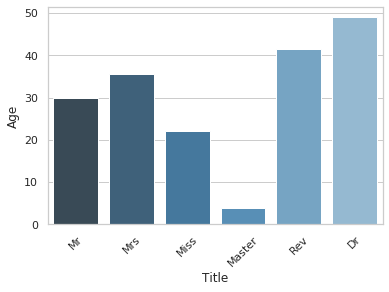

In [12]:
# Visualise median ages for each title used.
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, ci=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

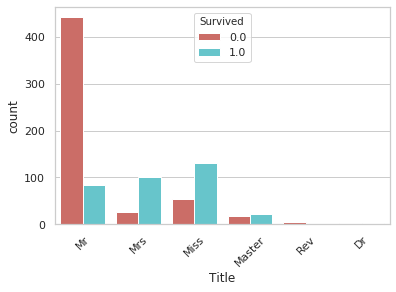

In [13]:
# visualise survival by title
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()